In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ---------------------------------------------
# 1) LOAD & PREPROCESS DATA
# ---------------------------------------------

df = pd.read_csv("../data/msk_2024_mutations_filtered.csv")
df = df.iloc[:, [0, 3] + list(range(266, len(df.columns)))]
df

,Patient,highest_stage_recorded,PIK3CA_Missense_Mutation_SNP_chr3,TP53_Missense_Mutation_SNP_chr17,GATA3_Frame_Shift_Ins_INS_chr10,ESR1_Missense_Mutation_SNP_chr6,ALK_Missense_Mutation_SNP_chr2,RNF43_Missense_Mutation_SNP_chr17,TSHR_Missense_Mutation_SNP_chr14,TP53_Nonsense_Mutation_SNP_chr17,...,DROSHA_Frame_Shift_Ins_INS_chr5,POLE_In_Frame_Del_DEL_chr12,ELF3_Splice_Site_SNP_chr1,HLA-B_Splice_Site_SNP_chr6,FANCA_Splice_Site_SNP_chr16,MDC1_In_Frame_Del_DEL_chr6,PREX2_Splice_Site_SNP_chr8,KMT2B_Splice_Site_SNP_chr19,NSD2_Frame_Shift_Ins_INS_chr4,MED12_Missense_Mutation_DNP_chr23
0,P-0000015,0,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,P-0000036,1,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,P-0000041,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,P-0000066,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,P-0000058,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23536,P-0087885,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23537,P-0089690,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23538,P-0089687,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
23539,P-0089676,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:


# Extract patient IDs
patient_ids = df['Patient'].values

# Get binary mutation features; convert to float32 for PyTorch
X = df.drop(columns='Patient').values.astype(np.float32)

# Get highest stage recorded; convert to float32 for PyTorch
y_true = df['highest_stage_recorded'].values.astype(np.float32)

num_positives = np.sum(X, axis=0)
num_negatives = X.shape[0] - num_positives
pos_weight = num_negatives / (num_positives + 1e-6)  # Avoid division by zero
print(pos_weight)
pos_weight = torch.tensor(pos_weight, dtype=torch.float32)

latent_dim = 128
batch_size = 1024

[1.5414013e+00 5.7336955e+00 1.8125448e+00 ... 2.1390908e+03 2.3530999e+03
 2.1390908e+03]


In [4]:
# ---------------------------------------------
# 3) DEFINE THE AUTOENCODER MODEL
# ---------------------------------------------
class MutationAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=128):
        super(MutationAutoencoder, self).__init__()
        # ENCODER: input_dim -> 512 -> 256 -> latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(256, latent_dim)
        )
        # DECODER: latent_dim -> 256 -> 512 -> input_dim
        # Note: We do NOT apply a final Sigmoid here because BCEWithLogitsLoss expects logits.
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(512, input_dim)
            # We do not use Sigmoid here as BCEWithLogitsLoss applies sigmoid internally.
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon_logits = self.decoder(z)
        return x_recon_logits
    
latent_dim = 128
batch_size = 1024

In [5]:

# ---------------------------------------------
# 4) DEFINE A CUSTOM DATASET
# ---------------------------------------------
class MutationDataset(Dataset):
    def __init__(self, X, y):
        
        # Convert to torch tensors if needed
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X)
        if not isinstance(y, torch.Tensor):
            y = torch.from_numpy(y)
            
        self.X = X.float()
        self.y = y.float()

    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        """
        Returns:
          x_in      : the input features to the autoencoder
          x_target  : same as x_in for reconstruction
          y_label   : the binary label for classification
        """
        x_in = self.X[idx]
        x_target = self.X[idx]
        y_label = self.y[idx]
        
        return x_in, x_target, y_label
    
dataset = MutationDataset(X, y_true)
n = len(dataset)
n_train = int(0.85 * n)
n_val = n - n_train
train_ds, val_ds = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)


In [6]:

# ---------------------------------------------
# 5) TRAINING & EVALUATION LOOP
# ---------------------------------------------
num_epochs = 50
lr = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MutationAutoencoder(input_dim=X.shape[1], latent_dim=latent_dim)
model.to(device)

# Use BCEWithLogitsLoss with the computed pos_weight.
# pos_weight should be of shape (input_dim,)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_x, batch_target, _ in train_loader:
        batch_x = batch_x.to(device)
        batch_target = batch_target.to(device)
        # Forward pass: note that model returns logits.
        logits = model(batch_x)
        loss = criterion(logits, batch_target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(batch_x)
    avg_train_loss = train_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_target, _ in val_loader:
            batch_x = batch_x.to(device)
            batch_target = batch_target.to(device)
            logits = model(batch_x)
            loss = criterion(logits, batch_target)
            val_loss += loss.item() * len(batch_x)
    avg_val_loss = val_loss / len(val_loader.dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
            f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
print("Training complete.")


Epoch [1/50] Train Loss: 1.4980 | Val Loss: 1.4197
Epoch [2/50] Train Loss: 1.1633 | Val Loss: 1.4866
Epoch [3/50] Train Loss: 1.0318 | Val Loss: 1.1486
Epoch [4/50] Train Loss: 0.9639 | Val Loss: 0.9303
Epoch [5/50] Train Loss: 0.9111 | Val Loss: 0.8575
Epoch [6/50] Train Loss: 0.8625 | Val Loss: 0.7926
Epoch [7/50] Train Loss: 0.8144 | Val Loss: 0.7451
Epoch [8/50] Train Loss: 0.7649 | Val Loss: 0.6956
Epoch [9/50] Train Loss: 0.7176 | Val Loss: 0.6489
Epoch [10/50] Train Loss: 0.6781 | Val Loss: 0.6124
Epoch [11/50] Train Loss: 0.6398 | Val Loss: 0.5764
Epoch [12/50] Train Loss: 0.6059 | Val Loss: 0.5494
Epoch [13/50] Train Loss: 0.5753 | Val Loss: 0.5255
Epoch [14/50] Train Loss: 0.5479 | Val Loss: 0.5049
Epoch [15/50] Train Loss: 0.5270 | Val Loss: 0.4897
Epoch [16/50] Train Loss: 0.5066 | Val Loss: 0.4777
Epoch [17/50] Train Loss: 0.4887 | Val Loss: 0.4609
Epoch [18/50] Train Loss: 0.4718 | Val Loss: 0.4492
Epoch [19/50] Train Loss: 0.4581 | Val Loss: 0.4382
Epoch [20/50] Train L

In [ ]:
# After training, extract the latent representations for the entire dataset.
full_dataset = MutationDataset(X, y_true)
model.eval()
all_latents = []

with torch.no_grad():
    full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)
    for batch_x, _, _ in full_loader:
        batch_x = batch_x.to(device)
        z = model.encoder(batch_x)
        all_latents.append(z.cpu().numpy())
all_latents = np.concatenate(all_latents, axis=0)  # (num_samples, latent_dim)

# Save latent representations along with patient IDs to CSV.
latent_cols = [f"latent_{i}" for i in range(latent_dim)]
latent_df = pd.DataFrame(all_latents, columns=latent_cols)
latent_df.insert(0, "Patient", patient_ids)
latent_df.to_csv("../data/latent_representations.csv", index=False)
print("Saved latent representations to 'latent_representations.csv'.")


Saved latent representations to 'latent_representations.csv'.


Latent shape: (23541, 128)


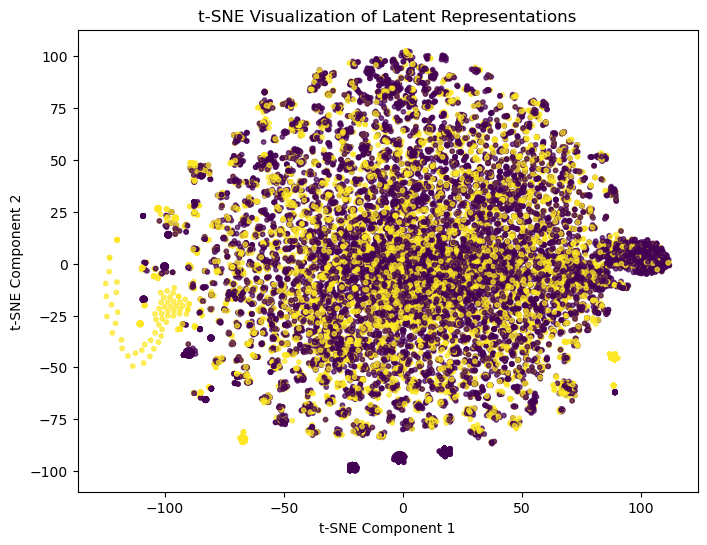

In [8]:
model.eval()
latent_list = []
labels_list = []
with torch.no_grad():
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    for batch_x, _, y_label in loader:
        batch_x = batch_x.to(device)
        z = model.encoder(batch_x)
        latent_list.append(z.cpu().numpy())
        labels_list.append(y_label.numpy())

latent_all = np.concatenate(latent_list, axis=0)
labels_all = np.concatenate(labels_list, axis=0)
print("Latent shape:", latent_all.shape)

# Use t-SNE to reduce latent dimensions to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_all)

plt.figure(figsize=(8,6))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels_all, cmap='viridis', s=10, alpha=0.7)
plt.title("t-SNE Visualization of Latent Representations")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
# save plot
plt.savefig("../fig/latent_tsne.png")
plt.show()
